# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [19]:
num_campaigns = 52944 
num_campaigns

52944

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly as px
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn import set_config
set_config(transform_output="pandas")

In [53]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [54]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Checking for duplicates and removing them

In [56]:
df.duplicated().sum()

12

In [57]:
df = df.drop_duplicates()

In [58]:
df.duplicated().sum()

0

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

#### There are many categorical features which need to be Ordinal or OneHot encoded

In [60]:
df['month'].value_counts()

month
may    13767
jul     7169
aug     6176
jun     5318
nov     4100
apr     2631
oct      717
sep      570
mar      546
dec      182
Name: count, dtype: int64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Based on inputs on customer, bank and campaign calls, predict if the customer is bound to sign up for term deposit.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [64]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [68]:
for col in df.select_dtypes(include = 'object').columns:
    cond = (df[col] == 'unknown')
    df[col] = np.where(cond, np.nan, df[col])
    print(df[col].value_counts())

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: count, dtype: int64
marital
married     24921
single      11564
divorced     4611
Name: count, dtype: int64
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
illiterate                18
Name: count, dtype: int64
default
no     32577
yes        3
Name: count, dtype: int64
housing
yes    21571
no     18615
Name: count, dtype: int64
loan
no     33938
yes     6248
Name: count, dtype: int64
contact
cellular     26135
telephone    15041
Name: count, dtype: int64
month
may    13767
jul     7169
aug     6176
jun     5318
nov     4100
apr     2631
oct      717
sep      570
mar      546
dec      182
Name:

In [71]:
df = df.dropna()

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30478 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30478 non-null  int64  
 1   job             30478 non-null  object 
 2   marital         30478 non-null  object 
 3   education       30478 non-null  object 
 4   default         30478 non-null  object 
 5   housing         30478 non-null  object 
 6   loan            30478 non-null  object 
 7   contact         30478 non-null  object 
 8   month           30478 non-null  object 
 9   day_of_week     30478 non-null  object 
 10  duration        30478 non-null  int64  
 11  campaign        30478 non-null  int64  
 12  pdays           30478 non-null  int64  
 13  previous        30478 non-null  int64  
 14  poutcome        30478 non-null  object 
 15  emp.var.rate    30478 non-null  float64
 16  cons.price.idx  30478 non-null  float64
 17  cons.conf.idx   30478 non-null  floa

In [73]:
for col in df.select_dtypes(include = 'object').columns:
    print(df[col].value_counts())

job
admin.           8734
blue-collar      5674
technician       5469
services         2856
management       2311
retired          1215
self-employed    1092
entrepreneur     1089
unemployed        738
housemaid         690
student           610
Name: count, dtype: int64
marital
married     17487
single       9439
divorced     3552
Name: count, dtype: int64
education
university.degree      10408
high.school             7697
professional.course     4318
basic.9y                4276
basic.4y                2380
basic.6y                1388
illiterate                11
Name: count, dtype: int64
default
no     30475
yes        3
Name: count, dtype: int64
housing
yes    16516
no     13962
Name: count, dtype: int64
loan
no     25710
yes     4768
Name: count, dtype: int64
contact
cellular     20435
telephone    10043
Name: count, dtype: int64
month
may    9731
jul    5077
aug    4672
jun    3614
nov    3495
apr    2114
oct     641
sep     495
mar     482
dec     157
Name: count, dtype: int64


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [81]:
ohe = OneHotEncoder(drop = 'if_binary', sparse_output=False, handle_unknown="ignore")

ct = ColumnTransformer(transformers=[
    ("ohe", ohe, ['poutcome','contact','loan', 'housing', 'default', 'marital', 'y'] )],
    remainder='passthrough', verbose_feature_names_out=False
)

#ct.set_output(transform="pandas")
df_transformed = ct.fit_transform(df)
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30478 entries, 0 to 41187
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   poutcome_failure      30478 non-null  float64
 1   poutcome_nonexistent  30478 non-null  float64
 2   poutcome_success      30478 non-null  float64
 3   contact_telephone     30478 non-null  float64
 4   loan_yes              30478 non-null  float64
 5   housing_yes           30478 non-null  float64
 6   default_yes           30478 non-null  float64
 7   marital_divorced      30478 non-null  float64
 8   marital_married       30478 non-null  float64
 9   marital_single        30478 non-null  float64
 10  y_yes                 30478 non-null  float64
 11  age                   30478 non-null  int64  
 12  job                   30478 non-null  object 
 13  education             30478 non-null  object 
 14  month                 30478 non-null  object 
 15  day_of_week           30

In [82]:
le = LabelEncoder()
df_transformed['job'] = le.fit_transform(df_transformed['job'])
df_transformed['education'] = le.fit_transform(df_transformed['education'])
df_transformed['day_of_week'] = le.fit_transform(df_transformed['day_of_week'])
df_transformed['month'] = le.fit_transform(df_transformed['month'])
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30478 entries, 0 to 41187
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   poutcome_failure      30478 non-null  float64
 1   poutcome_nonexistent  30478 non-null  float64
 2   poutcome_success      30478 non-null  float64
 3   contact_telephone     30478 non-null  float64
 4   loan_yes              30478 non-null  float64
 5   housing_yes           30478 non-null  float64
 6   default_yes           30478 non-null  float64
 7   marital_divorced      30478 non-null  float64
 8   marital_married       30478 non-null  float64
 9   marital_single        30478 non-null  float64
 10  y_yes                 30478 non-null  float64
 11  age                   30478 non-null  int64  
 12  job                   30478 non-null  int64  
 13  education             30478 non-null  int64  
 14  month                 30478 non-null  int64  
 15  day_of_week           30

In [84]:
for col in df_transformed.columns:
    print(df_transformed[col].value_counts())

poutcome_failure
0.0    27017
1.0     3461
Name: count, dtype: int64
poutcome_nonexistent
1.0    25826
0.0     4652
Name: count, dtype: int64
poutcome_success
0.0    29287
1.0     1191
Name: count, dtype: int64
contact_telephone
0.0    20435
1.0    10043
Name: count, dtype: int64
loan_yes
0.0    25710
1.0     4768
Name: count, dtype: int64
housing_yes
1.0    16516
0.0    13962
Name: count, dtype: int64
default_yes
0.0    30475
1.0        3
Name: count, dtype: int64
marital_divorced
0.0    26926
1.0     3552
Name: count, dtype: int64
marital_married
1.0    17487
0.0    12991
Name: count, dtype: int64
marital_single
0.0    21039
1.0     9439
Name: count, dtype: int64
y_yes
0.0    26620
1.0     3858
Name: count, dtype: int64
age
31    1643
32    1554
33    1524
30    1441
34    1431
      ... 
91       2
89       2
95       1
87       1
94       1
Name: count, Length: 76, dtype: int64
job
0     8734
1     5674
9     5469
7     2856
4     2311
5     1215
6     1092
2     1089
10     738
3 

<Axes: xlabel='education', ylabel='y_yes'>

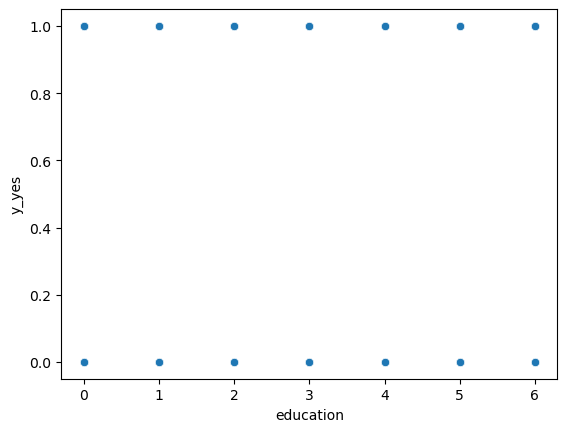

In [93]:
sns.scatterplot(data=df_transformed, x='education', y='y_yes')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [94]:
X = df_transformed.drop(columns=['y_yes'], axis=1)
y = df_transformed['y_yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=22, shuffle=True, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [108]:
y.value_counts()

y_yes
0.0    26620
1.0     3858
Name: count, dtype: int64

In [115]:
dummy_pipe = Pipeline([('scaler', StandardScaler()),
                      ('baseline', DummyClassifier(strategy='stratified',random_state=42))])
dummy_pipe.fit(X_train, y_train)
print(classification_report(y_test, dummy_pipe.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88      5324
         1.0       0.13      0.13      0.13       772

    accuracy                           0.78      6096
   macro avg       0.50      0.50      0.50      6096
weighted avg       0.78      0.78      0.78      6096



#### Unbalanced dataset. If the baseline was to predict the majority class, we get zero recall score. Recall score for value 1 is very important for our classification problem. We want to correctly identify all candidates who will accept term deposit. DummyClassifier with stratified option would be a better baseline model even though the recall score is very less.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [118]:
lgr_pipe = Pipeline([('scaler', StandardScaler()),
                      ('baseline', LogisticRegression(fit_intercept=True,random_state=42))])
lgr_pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('baseline', LogisticRegression(random_state=42))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [119]:
print(classification_report(y_test, lgr_pipe.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      5324
         1.0       0.64      0.41      0.50       772

    accuracy                           0.90      6096
   macro avg       0.78      0.69      0.72      6096
weighted avg       0.88      0.90      0.89      6096



#### Definitely better than baseline but recall/precision needs to be improved further

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions